In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import torch
import torch.nn as nn

class ConvNet1D(nn.Module):
    def __init__(self):
        super(ConvNet1D, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        # Second convolutional layer
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Third convolutional layer
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        # First fully connected layer
        self.fc1 = nn.Linear(64 * 3, 128)
        # Second fully connected layer
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # First conv layer
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)

        # Second conv layer
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool(x)

        # Third conv layer
        x = self.conv3(x)
        x = torch.relu(x)
        x = self.pool(x)

        # Flatten the output for the fully connected layers
        x = x.view(-1, 64 * 3)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)

        return x


In [3]:
class GradCAM1D:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.feature_map = None
        self.gradients = None

        # Set model in evaluation mode
        self.model.eval()

    def compute_gradcam(self, input_tensor, target_class):
        # Register hooks
        hook = self._register_hooks()

        # Forward pass
        output = self.model(input_tensor)

        # Backward pass
        self._backward_pass(output, target_class)

        # Compute GradCAM
        grad_cam = self._compute_gradcam()

        # Remove hooks
        self._remove_hooks(hook)

        return grad_cam.squeeze()

    def _register_hooks(self):
        def hook_fn(module, input, output):
            self.feature_map = output.detach()

        def back_hook_fn(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        target_layer = self._find_layer(self.target_layer)
        hook = target_layer.register_forward_hook(hook_fn)
        back_hook = target_layer.register_backward_hook(back_hook_fn)
        return hook, back_hook

    def _backward_pass(self, output, target_class):
        self.model.zero_grad()
        loss = output[0, target_class]
        loss.backward()

    def _compute_gradcam(self):
        weights = torch.mean(self.gradients, -1)
        grad_cam = self._linear_combination(self.feature_map, weights)
        return grad_cam

    def _remove_hooks(self, hooks):
        for hook in hooks:
            hook.remove()

    def _find_layer(self, layer_name):
        for name, module in self.model.named_modules():
            if name == layer_name:
                return module
        raise RuntimeError("Target layer '{}' not found in the model.".format(layer_name))

    def _linear_combination(self, feature_map, weights):
        result = torch.sum(feature_map.unsqueeze(-1) * weights.unsqueeze(2).unsqueeze(3), dim=1).squeeze(-1)
        return result


In [4]:
input = torch.rand(1, 3, 100)

model = ConvNet1D()
model.to("cuda:0")
gradcam = GradCAM1D(model, 'conv3')

heatmap = gradcam.compute_gradcam(input.to("cuda:0"), 1)
heatmap.shape, input.shape

/home/arthur.babey/miniconda3/envs/efs/lib/python3.11/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


(torch.Size([25]), torch.Size([1, 3, 100]))

In [ ]:
# CHAT GPT one

Computed Grad-CAM: tensor([2.1389e-05, 0.0000e+00, 1.6178e-04, 9.3469e-05, 2.7032e-04, 0.0000e+00,
        0.0000e+00, 2.1543e-04, 5.1992e-05, 1.3125e-04, 3.3708e-04, 1.7995e-05,
        9.5757e-05, 2.1831e-04, 9.0095e-05, 7.0586e-05, 2.8900e-04, 0.0000e+00,
        1.2700e-04, 7.7567e-05, 7.2609e-05, 1.5303e-04, 0.0000e+00, 2.6128e-04,
        2.4634e-04, 0.0000e+00, 3.2839e-04, 0.0000e+00, 0.0000e+00, 3.1176e-04,
        9.5932e-05, 2.4683e-04, 5.9720e-05, 2.3160e-04, 3.4004e-04, 0.0000e+00,
        1.3486e-04, 3.0239e-04, 2.1577e-06, 1.6608e-04, 2.0205e-04, 2.8966e-04,
        1.1271e-04, 2.0657e-04, 3.3193e-04, 0.0000e+00, 2.0488e-04, 4.5825e-04,
        0.0000e+00, 3.6297e-04, 1.7541e-04, 8.0995e-05, 2.8970e-04, 2.3641e-04,
        3.2991e-04, 0.0000e+00, 2.3487e-04, 2.9473e-04, 3.1404e-04, 7.3778e-04,
        0.0000e+00, 4.2554e-04, 0.0000e+00, 3.9994e-04, 0.0000e+00, 0.0000e+00,
        1.4779e-04, 0.0000e+00, 7.2553e-05, 1.6083e-04, 1.0511e-04, 0.0000e+00,
        1.7154e-04, 1

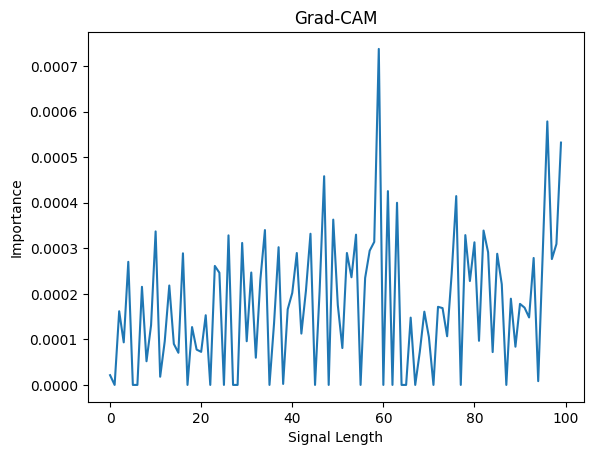

In [10]:
import torch
import torch.nn.functional as F

class GradCAM1D:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hooks = []  # List to store hook handles
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        # Attach hooks and store the handles
        self.hooks.append(self.target_layer.register_forward_hook(forward_hook))
        self.hooks.append(self.target_layer.register_backward_hook(backward_hook))

    def remove_hooks(self):
        # Remove all hooks in the list
        for hook in self.hooks:
            hook.remove()
        self.hooks = []  # Clear the list of hooks

    def compute_cam(self, input_tensor, target_category=None):
        output = self.model(input_tensor)
        if target_category is None:
            target_category = torch.argmax(output)
        
        self.model.zero_grad()
        one_hot_output = torch.zeros_like(output)
        one_hot_output[0, target_category] = 1
        output.backward(gradient=one_hot_output, retain_graph=True)

        guided_gradients = self.gradients
        alpha = guided_gradients.mean(dim=2, keepdim=True)
        cam = F.relu(torch.sum(alpha * self.activations, dim=1)).squeeze(0)
        
        return cam

import torch
import torch.nn as nn
import torch.nn.functional as F

class Simple1DConvNet(nn.Module):
    def __init__(self):
        super(Simple1DConvNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, 2)  # Assume binary classification

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)  # Flatten the features
        x = self.fc(x)
        return x


# Create the model
model = Simple1DConvNet()
model.eval()  # Set the model to evaluation mode

# Identify the target layer
target_layer = model.conv3  # Use the last convolutional layer

# Instantiate GradCAM1D
grad_cam = GradCAM1D(model, target_layer)

# Create a random input tensor
input_tensor = torch.randn(1, 1, 100)  # Shape: (batch_size, channels, length)

# Compute Grad-CAM for a specific target category
target_category = 1  # Assuming we're interested in the second class
cam = grad_cam.compute_cam(input_tensor, target_category)

# Print or visualize the Grad-CAM output
print("Computed Grad-CAM:", cam)

# Clean up: Remove hooks to free memory
grad_cam.remove_hooks()
import matplotlib.pyplot as plt

# Assuming `cam` is the output from the Grad-CAM
plt.plot(cam.numpy())
plt.title('Grad-CAM')
plt.xlabel('Signal Length')
plt.ylabel('Importance')
plt.show()


In [12]:
cam.shape, input.shape

(torch.Size([100]), torch.Size([1, 3, 100]))

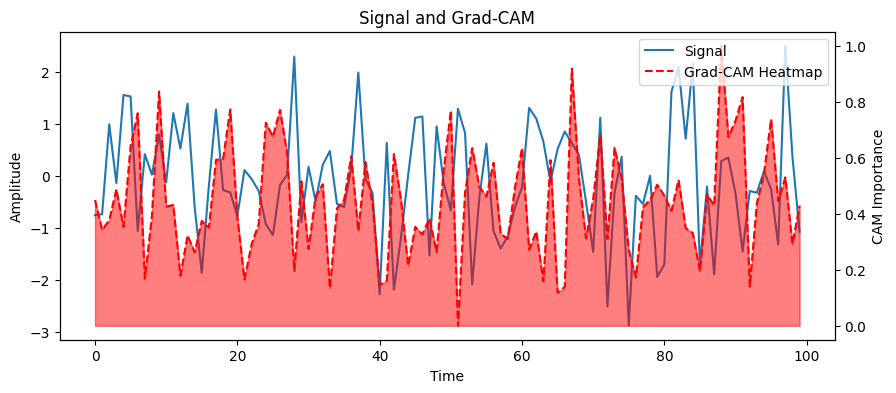

In [13]:
def normalize_cam(cam):
    cam -= cam.min()  # translate so the smallest value is 0
    cam /= cam.max()  # scale between 0 and 1
    return cam


import matplotlib.pyplot as plt
import numpy as np

def plot_signal_and_cam(signal, cam, title='Signal and Grad-CAM'):
    fig, ax = plt.subplots(figsize=(10, 4))
    t = np.arange(len(signal))

    # Normalize the CAM to make it easier to see on the plot
    cam_normalized = (cam - cam.min()) / (cam.max() - cam.min())

    # Plot the original signal
    ax.plot(t, signal, label='Signal')

    # Create a second y-axis to plot the heatmap
    ax2 = ax.twinx()
    ax2.plot(t, cam_normalized, color='red', linestyle='--', label='Grad-CAM Heatmap')

    # Fill under the curve
    ax2.fill_between(t, 0, cam_normalized, color='red', alpha=0.5)

    # Labels and title
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax2.set_ylabel('CAM Importance')
    ax.set_title(title)

    # Legend
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

    plt.show()

# Example usage with random data (replace these with actual data)
input_signal = torch.randn(100).numpy()  # Random 1D signal
grad_cam_output = torch.randn(100).numpy()  # Random Grad-CAM output for the signal

plot_signal_and_cam(input_signal, grad_cam_output)


/tmp/ipykernel_1677096/2223556573.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')  # Blue to red gradient


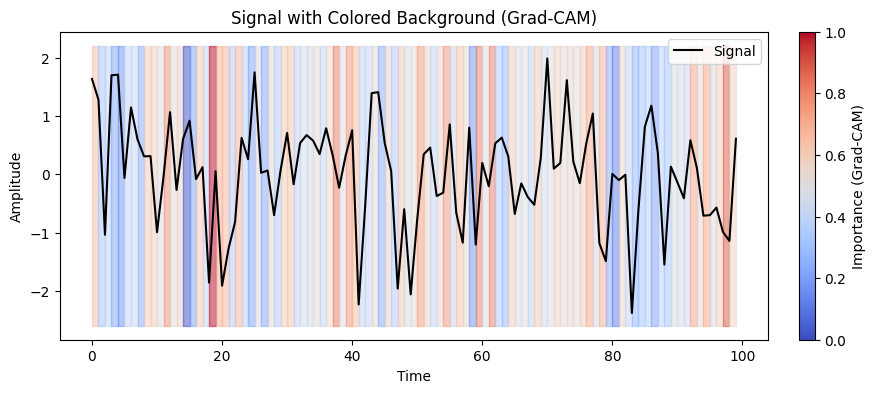

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm

def plot_full_background_cam(signal, cam, title='Signal with Colored Background (Grad-CAM)'):
    fig, ax = plt.subplots(figsize=(10, 4))
    t = np.arange(len(signal))

    # Normalize the CAM for colormap application
    cam_normalized = (cam - cam.min()) / (cam.max() - cam.min())

    # Signal Plot
    ax.plot(t, signal, label='Signal', color='black')

    # Create a color map
    cmap = cm.get_cmap('coolwarm')  # Blue to red gradient
    norm = mcolors.Normalize(vmin=0, vmax=1)

    # Determine the y-limits
    y_min, y_max = ax.get_ylim()

    # Fill the full background based on CAM values
    for i in range(len(t) - 1):
        ax.fill_between(t[i:i+2], y_min, y_max, color=cmap(norm(cam_normalized[i])), alpha=0.5)

    # Colorbar setup
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Importance (Grad-CAM)')

    # Labels and Title
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.set_title(title)
    
    # Legend
    ax.legend()

    plt.show()

# Example usage with random data (replace these with actual data)
input_signal = torch.randn(100).numpy()  # Random 1D signal
grad_cam_output = torch.randn(100).numpy()  # Random Grad-CAM output for the signal

plot_full_background_cam(input_signal, grad_cam_output)
